In [2]:
import requests
import io
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings("ignore")

In [3]:
def remove_corrs(df):
    
    corrs = df.corr().stack().reset_index()
    corrs.columns = ['1','2','R2']
    temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
    correlations = temp[temp.index % 2 == 0]
    
    corr_index = correlations['1'].value_counts().index
    to_drop = round(len(corr_index)*.9)
    
    df2 = df.drop(corr_index[:to_drop], axis = 1)
    
    return df2

In [4]:
def preprocess_data(df):
    
    df.index = pd.to_datetime(df.index)
    
    X = df.shift(1).dropna()
    
    X_data = remove_corrs(X)
    
    y = df['day_direction'].iloc[1:]
    
    train_num = round(len(X)*.8)
    test_num = round(len(X)*.2)
    print(train_num, test_num)
    
    X_train = X_data.iloc[:train_num]
    X_test = X_data.iloc[-test_num:]
    y_train = y.iloc[:train_num]
    y_test = y.iloc[-test_num:]
    
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
    
    return X_train, X_test, y_train, y_test

In [5]:
def logreg(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'penalty': ['l1', 'l2' ,'elasticnet'],
    'solver': ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}
    
    # Instantiate & fit LogReg model for GridSearch
    grid_logreg = LogisticRegression(random_state=42)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv,
                      scoring='accuracy', n_jobs = -1, error_score = 0)
    gs.fit(X_train, y_train)
        
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()

    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Accuracy: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)
    
    results = ['random forest', train_score, cv_results, test_score]
    
    return results

In [6]:
def dtree(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'max_depth': [3,10,15],
    'min_samples_split': [2,8,10,15],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Decision Tree model for GridSearch
    grid_dt = DecisionTreeClassifier()
    grid_dt.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_dt, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)

    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()

    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    
    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Accuracy: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test)
    
    results = ['decision tree', train_score, cv_results, test_score]
    
    return results

In [7]:
def random_forest(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'n_estimators': [75,90,100,110,115,125,150,500],
    'criterion': ['gini', 'entropy']}
    
    # Instantiate & fit Random Forest model for GridSearch
    grid_rf = RandomForestClassifier()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=grid_rf, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Accuracy: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')

    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);

    results = ['random forest', train_score, cv_results, test_score]
    
    return results

In [8]:
def xgboost(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'learning_rate': [.01,.05,.1,.5,1],
    'max_depth': [4],
    'min_child_weight': [3],
    'subsample': [1],
    'n_estimators': [100,500]}
    
    # Instantiate & fit XGClassifier
    xgb = XGBClassifier(verbosity=0, random_state=42)
    #xgb.fit(X_train, y_train)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=xgb, param_grid=grid, cv=cv, scoring='accuracy', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv).mean()

    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    print(f'Train Mean Accuracy: {train_score}')
    print(f'Mean Cross-Val Score: {cv_results}')
    print(f'Test Mean Accuracy: {test_score}')

    
    plot_confusion_matrix(gs, X_train, y_train)
    plot_confusion_matrix(gs, X_test, y_test);
    
    results = ['xgboost', train_score, cv_results, test_score]
    
    return results

In [10]:
files = [f for f in listdir('.\FormattedData')]

companies = []
for i in files:
    company = i.split('.')[0]
    companies.append(company)
    
test_companies = np.random.choice(companies, 16, replace = False)

1107 277
Train Mean Accuracy: 0.5257452574525745
Mean Cross-Val Accuracy: 0.5175981411275529
Test Mean Accuracy: 0.5018050541516246
Train Mean Accuracy: 0.5754290876242095
Mean Cross-Val Accuracy: 0.4932493579552403
Test Mean Accuracy: 0.5270758122743683
Train Mean Accuracy: 1.0
Mean Cross-Val Accuracy: 0.48962537197831313
Test Mean Accuracy: 0.51985559566787
Train Mean Accuracy: 1.0
Mean Cross-Val Score: 0.49231584525702166
Test Mean Accuracy: 0.5018050541516246
Train Mean Accuracy Score: 0.4742547425474255
Mean Cross-Val Score: 0.4850678733031675
Test Mean Accuracy Score: 0.4981949458483754
1798 450
Train Mean Accuracy: 0.5406006674082313
Mean Cross-Val Accuracy: 0.540600433302383
Test Mean Accuracy: 0.5
Train Mean Accuracy: 0.5672969966629589
Mean Cross-Val Accuracy: 0.5066542865985763
Test Mean Accuracy: 0.5177777777777778
Train Mean Accuracy: 1.0
Mean Cross-Val Accuracy: 0.489973692355308
Test Mean Accuracy: 0.4866666666666667
Train Mean Accuracy: 0.7352614015572859
Mean Cross-Val

FileNotFoundError: [Errno 2] No such file or directory: 'FormattedData/.csv'

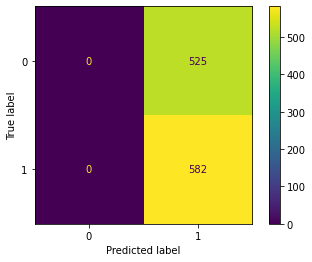

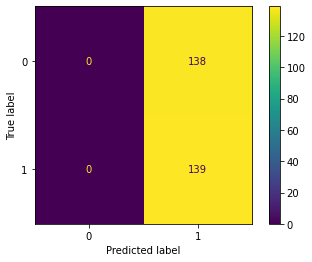

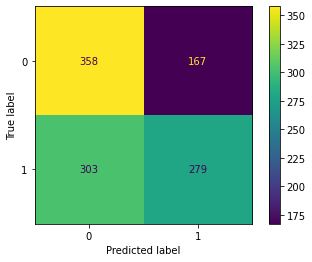

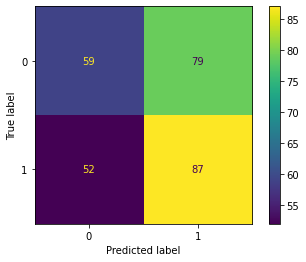

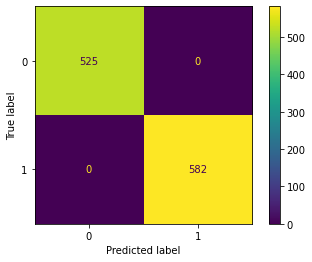

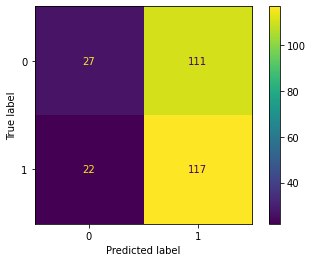

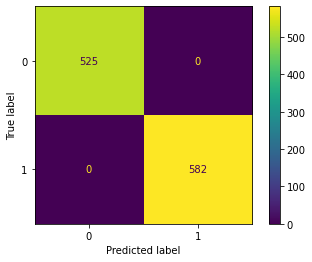

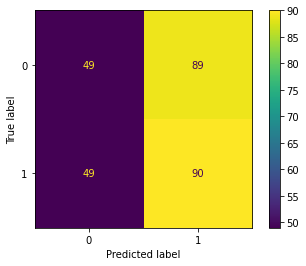

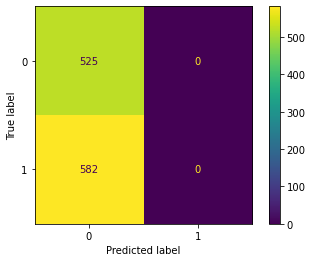

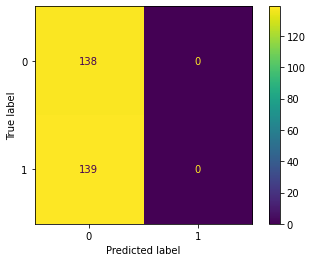

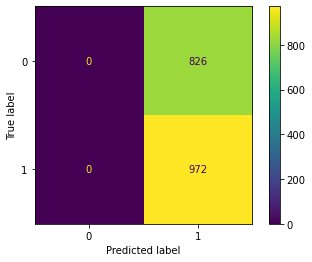

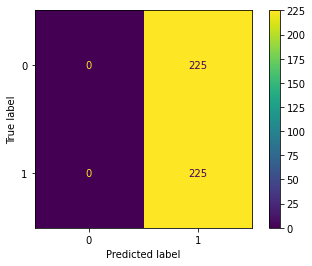

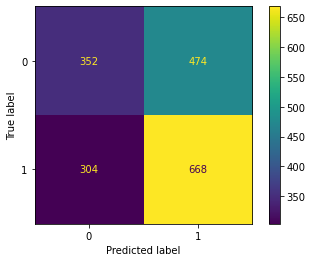

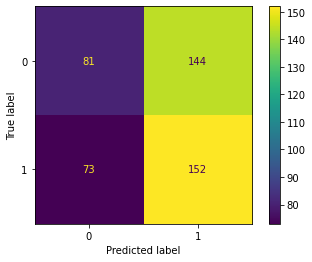

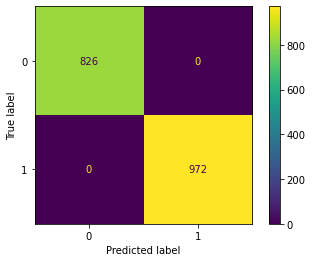

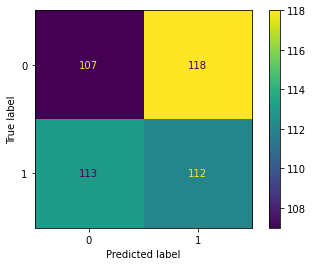

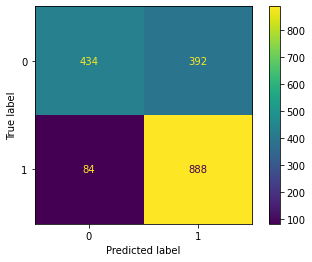

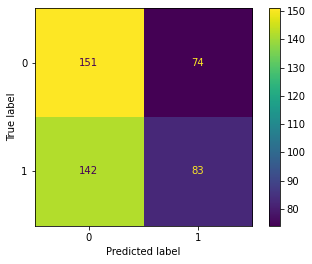

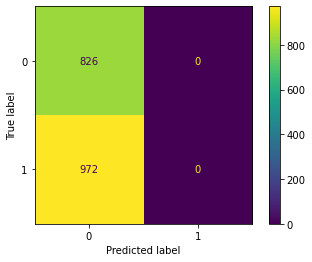

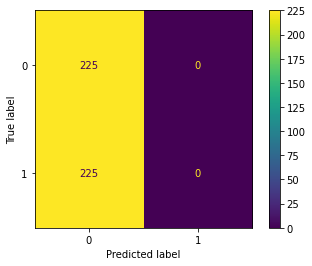

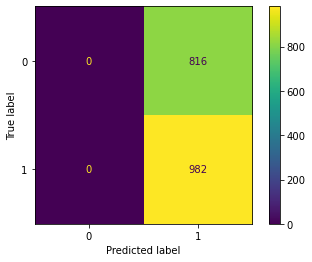

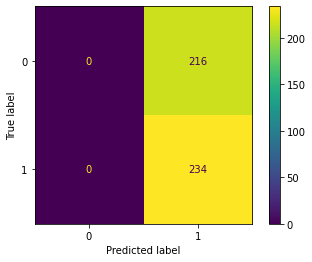

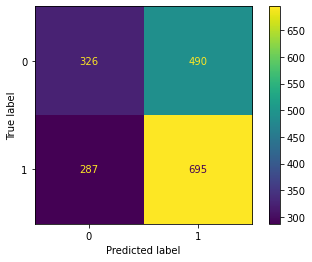

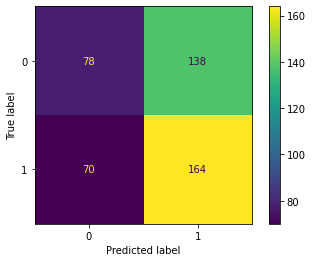

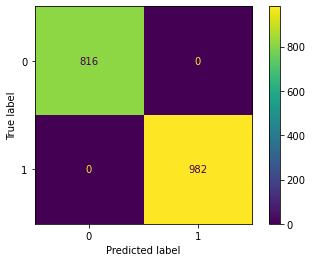

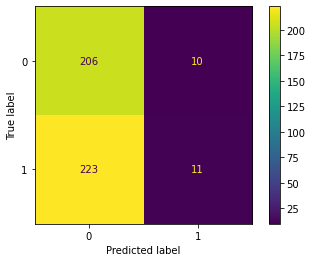

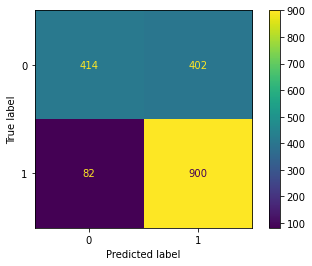

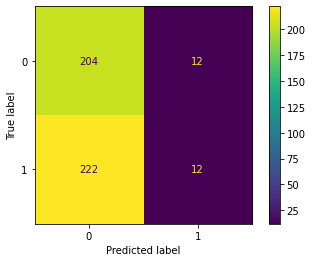

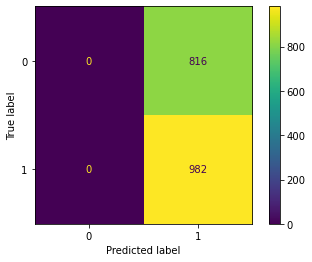

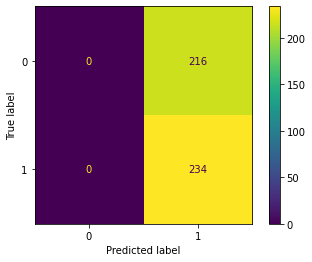

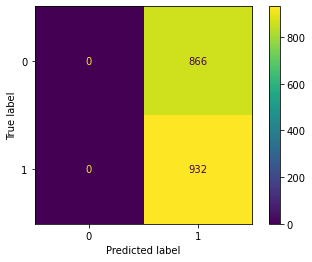

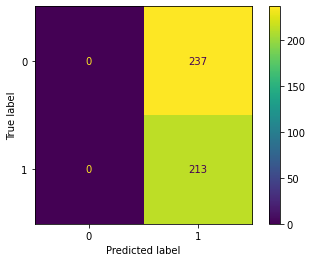

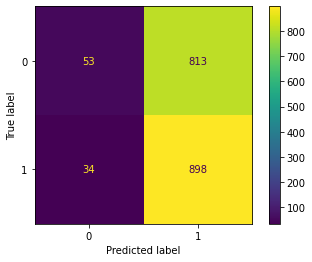

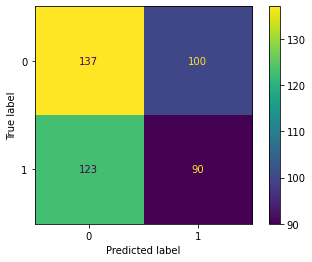

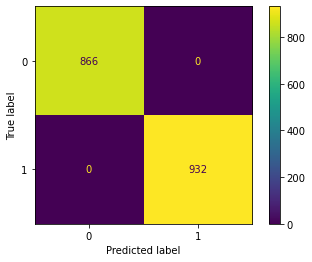

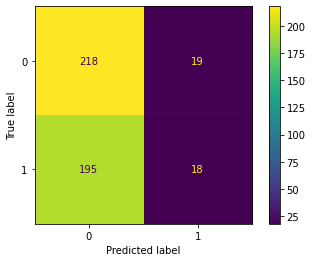

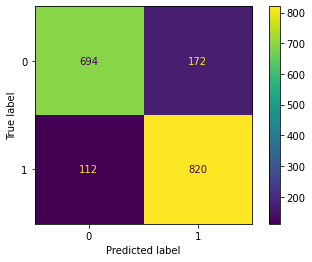

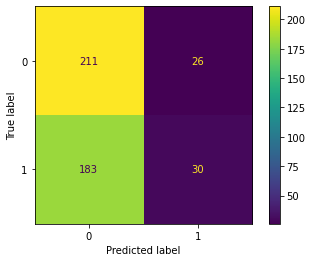

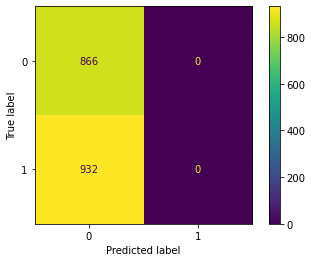

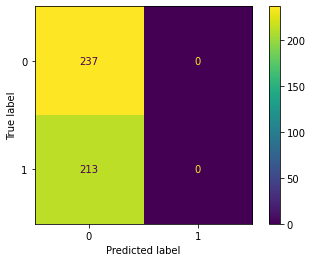

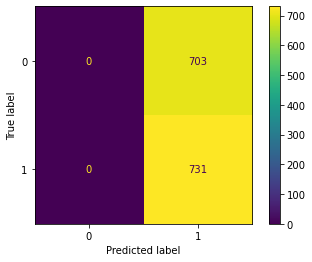

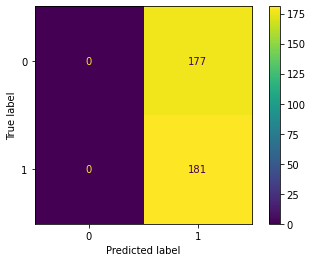

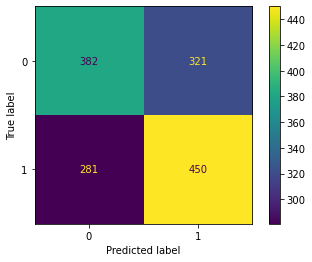

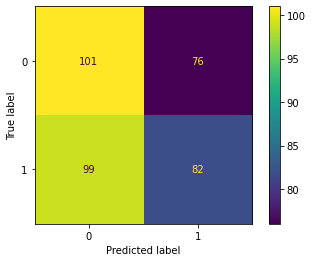

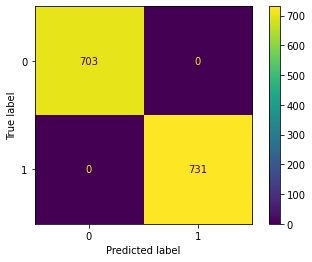

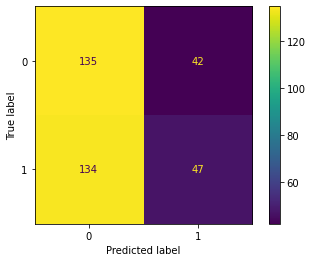

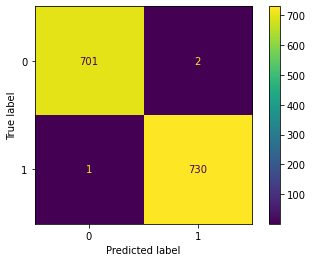

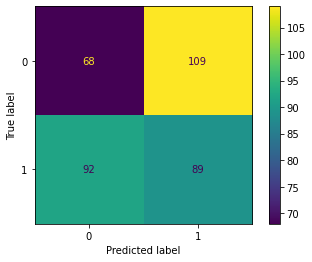

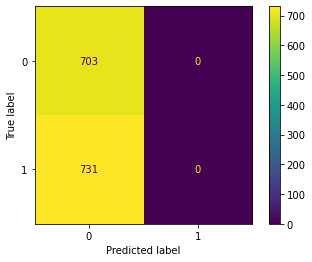

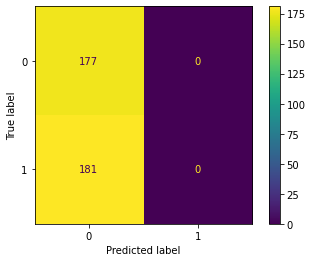

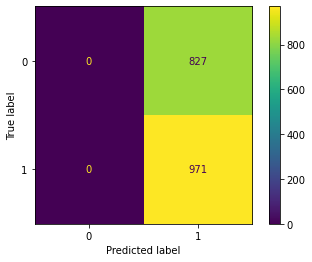

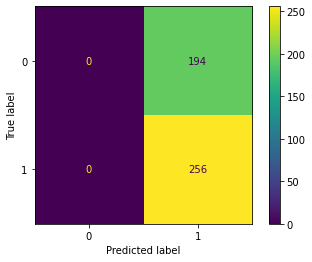

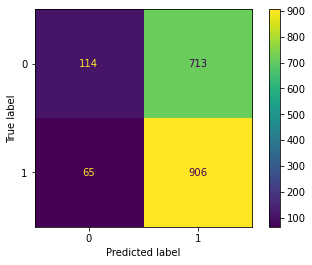

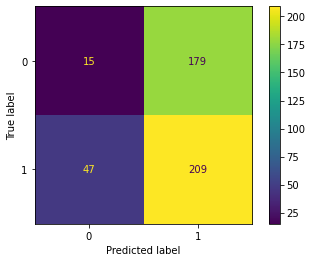

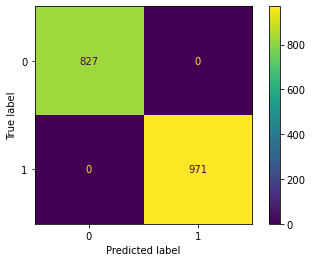

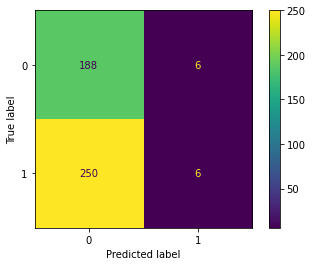

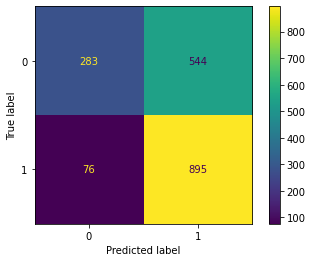

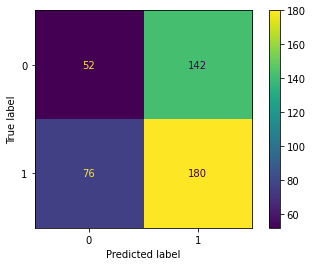

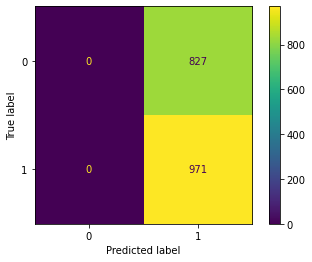

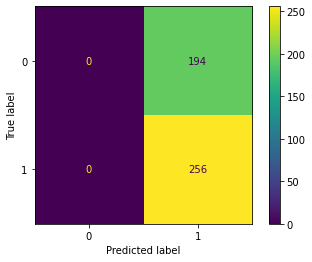

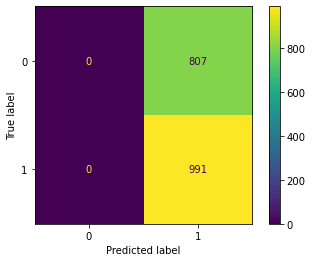

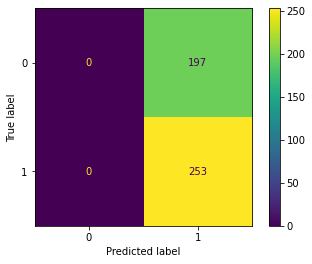

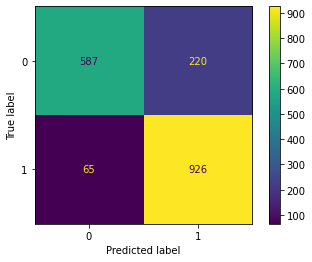

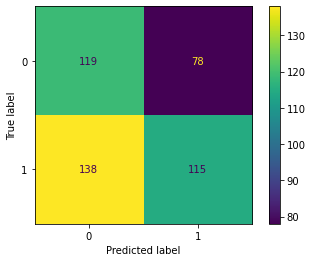

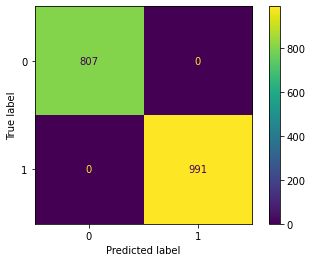

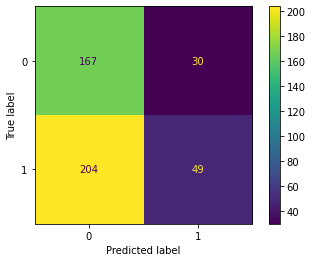

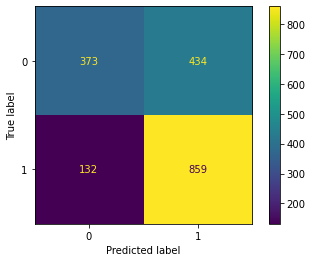

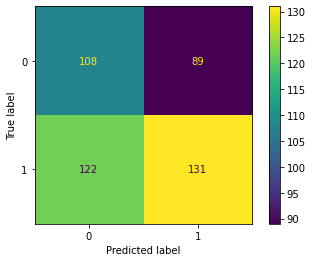

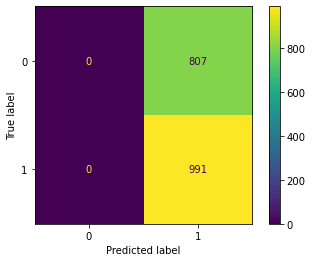

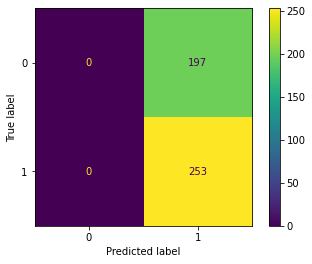

In [11]:
results = []

for c in test_companies:
    csv_for_df = f'FormattedData/{c}.csv'
    df = pd.read_csv(csv_for_df, index_col = 0)
    X_train, X_test, y_train, y_test = preprocess_data(df)
    logreg_results = logreg(X_train, X_test, y_train, y_test)
    dtree_results = dtree(X_train, X_test, y_train, y_test)
    randomforest_results = random_forest(X_train, X_test, y_train, y_test)
    xgboost_results = xgboost(X_train, X_test, y_train, y_test)
    c_results = pd.DataFrame([logreg_results, dtree_results, randomforest_results, xgboost_results],
            columns = ['Model Type', 'Train Accuracy', 'Cross Val Accuracy','Test Accuracy'])
    c_results['company'] = c.split('_')[0]
    results.append(c_results)

In [ ]:
best_results = pd.concat(results)
best_results.to_csv('ClassifierResults.csv')
best_results.sort_values('Test Accuracy', ascending = False)

In [ ]:
best_results.groupby('Model Type').mean().sort_values('Test Accuracy', ascending = False)

In [ ]:
best_results.to_csv('classifierresults')